# Testing bootstrapped ensemble test-set filter on preproject feature-set

In [15]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_cluster_filter as BE_cluster_filter
import helper


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from time import time
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array

import pprint
import pickle

figure_path = module_path + '/figures/'

# Load data, and select features

In [2]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TEST.ts')

In [3]:
from sklearn.model_selection import train_test_split

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))

X_train.head(10)


y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


k_range = list(range(1,8))
cluster_range = list(range(10,15))
thresh_range = [8]

weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

param_dict = BE_cluster_filter.hyperparam_search(X_train, y_train, X_val, y_val,
                                   clf_dict, grid_dict = grid_dict,
                                   clusters_list = cluster_range,
                                  thresh_list = thresh_range)

pprint.pprint(param_dict)

No matching indices predicted
No matching indices predicted
No matching indices predicted
No matching indices predicted
No matching indices predicted
No matching indices predicted
No matching indices predicted
No matching indices predicted
{'knnOptimal': {'custers': 10,
                'keep clusters': array([1, 2, 3, 4, 5, 6, 7, 8]),
                'threshold': 8},
 'nb': {'custers': 10,
        'keep clusters': array([1, 2, 4, 5, 6, 8]),
        'threshold': 8}}


In [7]:
param_dict = {'knnOptimal': {'custers': 10,
                'keep clusters': np.array([1, 2, 3, 4, 5, 6, 7, 8]),
                'threshold': 8}, 'nb': {'custers': 10,
        'keep clusters':np.array([1, 2, 4, 5, 6, 8]),
        'threshold': 8}}

clf_dict = {'knnOptimal': KNeighborsClassifier(n_neighbors=4, weights='distance'),
 'nb': GaussianNB()}

## Testing with the optimal hyperparameters

In [9]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, X_test, y_test, clf_dict,
                                     param_dict = param_dict)

auc_init, auc_filtered, _ = helper.get_auc_scores(X_test, y_test, clf_dict, indices)
print('AUC score for the initial classifiers: ')
pprint.pprint(auc_init)
print('AUC score for the filtered dataset: ')
pprint.pprint(auc_filtered)

AUC score for the initial classifiers: 
{'knnOptimal': 0.7558518615113778, 'nb': 0.604782914230655}
AUC score for the filtered dataset: 
{'knnOptimal': 0.7502860652565332, 'nb': 0.5742311171415648}


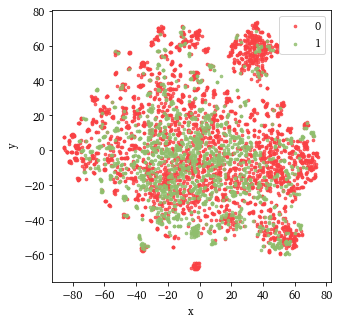

In [19]:
dim_red = 'tsne'
X_test_2d = helper.get_dim_reduced_X(X_train, dim_red, X_train, y_train)

f = helper.scatterplot_with_colors(X_test_2d, y_train.values)
f.savefig(figure_path + f'lung_sound_data_{dim_red}.pdf', bbox_inches='tight')

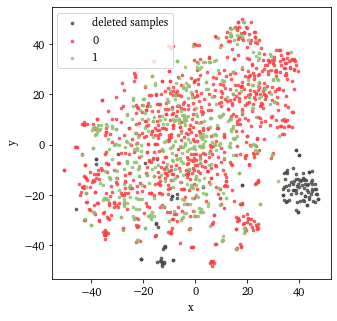

In [11]:
dim_red = 'tsne'
X_test_2d = helper.get_dim_reduced_X(X_test, dim_red, X_train, y_train)
mask=np.full(len(y_test),True,dtype=bool)
mask[indices['knnOptimal']]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = helper.scatterplot_with_colors(X_test_2d, new_y_test.values)
f.savefig(figure_path + f'lung_sound_data_cluster_filtered_{dim_red}.pdf', bbox_inches='tight')

In [17]:
ampl_list = [5, 10, 15, 20, 25, 30, 35, 40]
filtered = {}
init = {}
removed_data = {}
for ampl in ampl_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, ampl, 4)
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[ampl] = auc_filtered
    init[ampl] = auc_init
    removed_data[ampl] = rm_data
    
pprint.pprint(filtered, depth = 3)
pprint.pprint(init, depth = 3)
pprint.pprint(removed_data, depth = 3)

a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_cluster_amplitude.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

{5: {'knnOptimal': 0.7127808941131784, 'nb': 0.5685965900174468},
 10: {'knnOptimal': 0.7090469142372486, 'nb': 0.570558998758601},
 15: {'knnOptimal': 0.7091619318181819, 'nb': 0.5723318470733327},
 20: {'knnOptimal': 0.7094372506659952, 'nb': 0.572576560430141},
 25: {'knnOptimal': 0.7087442569708492, 'nb': 0.5721024390243903},
 30: {'knnOptimal': 0.7088838343881856, 'nb': 0.5721024390243903},
 35: {'knnOptimal': 0.7088838343881856, 'nb': 0.5734128351830151},
 40: {'knnOptimal': 0.7088838343881856, 'nb': 0.5729341329177599}}
{5: {'knnOptimal': 0.6883390203791847, 'nb': 0.576242637630132},
 10: {'knnOptimal': 0.6871364094093442, 'nb': 0.576242637630132},
 15: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 20: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 25: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 30: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 35: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 40: {'knnO

In [18]:
amount_list = [12, 10, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
filtered = {}
init = {}
removed_data = {}

for am in amount_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, 15, am)
    
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered , rm_data= helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[am] = auc_filtered
    init[am] = auc_init
    removed_data[am] = rm_data

    
pprint.pprint(filtered, depth = 3)
pprint.pprint(init, depth = 3)
pprint.pprint(removed_data, depth = 3)

a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_cluster_amount.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

{2: {'knnOptimal': 0.6469778108782258, 'nb': 0.575145223087381},
 3: {'knnOptimal': 0.6928871595330741, 'nb': 0.567737119623912},
 4: {'knnOptimal': 0.7091619318181819, 'nb': 0.5723318470733327},
 5: {'knnOptimal': 0.7217021548692372, 'nb': 0.5726478009290217},
 7: {'knnOptimal': 0.7323988039154501, 'nb': 0.5711265620595698},
 10: {'knnOptimal': 0.7358404348754956, 'nb': 0.5700406302338565},
 12: {'knnOptimal': 0.7401354067491802, 'nb': 0.5748715313463515}}
{2: {'knnOptimal': 0.6192794476683111, 'nb': 0.5656183666224744},
 3: {'knnOptimal': 0.6683764027442713, 'nb': 0.5728557663747075},
 4: {'knnOptimal': 0.687067585287576, 'nb': 0.576242637630132},
 5: {'knnOptimal': 0.7036107307672803, 'nb': 0.5805387117573335},
 7: {'knnOptimal': 0.7262864677287315, 'nb': 0.5970999688480291},
 10: {'knnOptimal': 0.7326943556975505, 'nb': 0.5983206914288612},
 12: {'knnOptimal': 0.7378308085747611, 'nb': 0.6014648670969984}}
{2: {'knnOptimal': 0.7782608695652173, 'nb': 0.5804347826086956},
 3: {'knnO